# **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import os
from google.colab import files
import shutil

# **1. Load Data**

In [3]:
# Reads the two CSV files into DataFrames.
historical_data_df = pd.read_csv('/content/historical_data.csv')
fear_greed_index_df = pd.read_csv('/content/fear_greed_index.csv')

In [4]:
historical_data_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [5]:
historical_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [6]:
fear_greed_index_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [7]:
fear_greed_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


# **2. Enhanced timestamp conversion function**

In [8]:
def convert_timestamp_to_datetime(df, col_name):
    """
    Converts timestamp column to a UTC datetime and date columns in pandas DataFrame.
    Check timestamp (seconds, milliseconds, microseconds).
    Adds two columns: 'datetime_utc' (full datetime) and 'date' (date only).
    """
    ts_sample = df[col_name].iloc[0]

    # Check timestamp unit based on magnitude
    if ts_sample > 1e14:
        unit = 'us'  # microseconds
    elif ts_sample > 1e11:
        unit = 'ms'  # milliseconds
    elif ts_sample > 1e9:
        unit = 's'   # seconds
    else:
        raise ValueError(
            f"Timestamp values in column '{col_name}' are invalid: {ts_sample}"
        )

    print(f"Timestamp unit for '{col_name}': {unit}")

    # Convert to datetime with timezone UTC
    df['datetime_utc'] = pd.to_datetime(df[col_name], unit=unit, utc=True)
    df['date'] = df['datetime_utc'].dt.date

    return df



# **3. Prepare Sentiment Data**

In [9]:
fear_greed_index_df = convert_timestamp_to_datetime(fear_greed_index_df, 'timestamp')
fear_greed_index_df['classification'].unique()

Timestamp unit for 'timestamp': s


array(['Fear', 'Extreme Fear', 'Neutral', 'Greed', 'Extreme Greed'],
      dtype=object)

In [10]:
# Map sentiment classifications to ordinal and binary
fear_greed_index_df['sent_bin'] = fear_greed_index_df['classification'].replace({
    'Extreme Fear': 0,
    'Fear': 0,
    'Neutral': 1,
    'Extreme Greed': 2,
    'Greed': 2
})

fear_greed_index_df['fear_greed_bin'] = fear_greed_index_df['classification'].map({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Extreme Greed': 'Greed',
    'Greed': 'Greed',
    'Neutral': 'Neutral'
})


/tmp/ipython-input-1517406304.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fear_greed_index_df['sent_bin'] = fear_greed_index_df['classification'].replace({


# **4. Prepare Trade Data**

In [11]:
historical_data_df.columns = historical_data_df.columns.str.lower().str.replace(' ', '_')
historical_data_df = convert_timestamp_to_datetime(historical_data_df, 'timestamp')

numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee']
for col in numeric_cols:
    historical_data_df[col] = pd.to_numeric(historical_data_df[col], errors='coerce')




Timestamp unit for 'timestamp': ms


In [12]:
historical_data_df[numeric_cols].isna().sum()


,0
execution_price,0
size_tokens,0
size_usd,0
closed_pnl,0
fee,0


# **5. Aggregate Daily Trade Metrics**

In [13]:
daily_metrics = historical_data_df.groupby('date').agg(
    total_trades=('execution_price', 'count'),
    total_volume_usd=('size_usd', 'sum'),
    avg_trade_size_usd=('size_usd', 'mean'),
    total_pnl=('closed_pnl', 'sum'),
    win_rate=('closed_pnl', lambda x: (x > 0).mean()),
    pct_buy=('side', lambda x: sum(x == 'BUY') / len(x)),
    fees_paid=('fee', 'sum')
).reset_index() # makes date a column again.


# **6. Merge Sentiment and Trade Data on Date**

In [14]:
merged_df = daily_metrics.merge(
    fear_greed_index_df[['date', 'classification', 'sent_bin', 'fear_greed_bin']],
    on='date',
    how='left'
)
merged_df.head()

,date,total_trades,total_volume_usd,avg_trade_size_usd,total_pnl,win_rate,pct_buy,fees_paid,classification,sent_bin,fear_greed_bin
0,2023-03-28,3,4.770000e+02,159.000000,0.000000e+00,0.000000,1.000000,0.000000,Greed,2.0,Greed
1,2023-11-14,1045,1.155543e+07,11057.827522,1.555034e+02,0.274641,0.469856,2794.570654,Greed,2.0,Greed
2,2024-03-09,6962,3.940677e+07,5660.265764,1.769655e+05,0.490089,0.484200,6812.781233,Extreme Greed,2.0,Greed
3,2024-07-03,7141,2.184323e+07,3058.848110,1.587424e+05,0.317182,0.490828,8743.877486,Neutral,1.0,Neutral
4,2024-10-27,35241,1.039478e+08,2949.625864,3.189461e+06,0.451605,0.423569,21539.462735,Greed,2.0,Greed


In [15]:
merged_df['classification'].isna().sum()

np.int64(1)

# **7. Exploratory Data Analysis (EDA) - Visualization**

#1. Overview statistics

In [16]:
# Full descriptive summary of all columns
print("\n=== Descriptive Statistics ===")
print(merged_df.describe(include='all'))


=== Descriptive Statistics ===
              date   total_trades  total_volume_usd  avg_trade_size_usd  \
count            7       7.000000      7.000000e+00            7.000000   
unique           7            NaN               NaN                 NaN   
top     2023-03-28            NaN               NaN                 NaN   
freq             1            NaN               NaN                 NaN   
mean           NaN   30174.857143      1.701696e+08         5664.834996   
std            NaN   47639.566148      2.589642e+08         4240.128294   
min            NaN       3.000000      4.770000e+02          159.000000   
25%            NaN    4003.500000      1.669933e+07         3004.236987   
50%            NaN    7141.000000      3.940677e+07         5259.977837   
75%            NaN   31101.000000      2.071115e+08         8359.046643   
max            NaN  133871.000000      7.041585e+08        11508.299879   

           total_pnl  win_rate   pct_buy      fees_paid classificat

In [17]:
os.makedirs('/content/outputs', exist_ok=True)

# 2. Distribution plots for key metrics

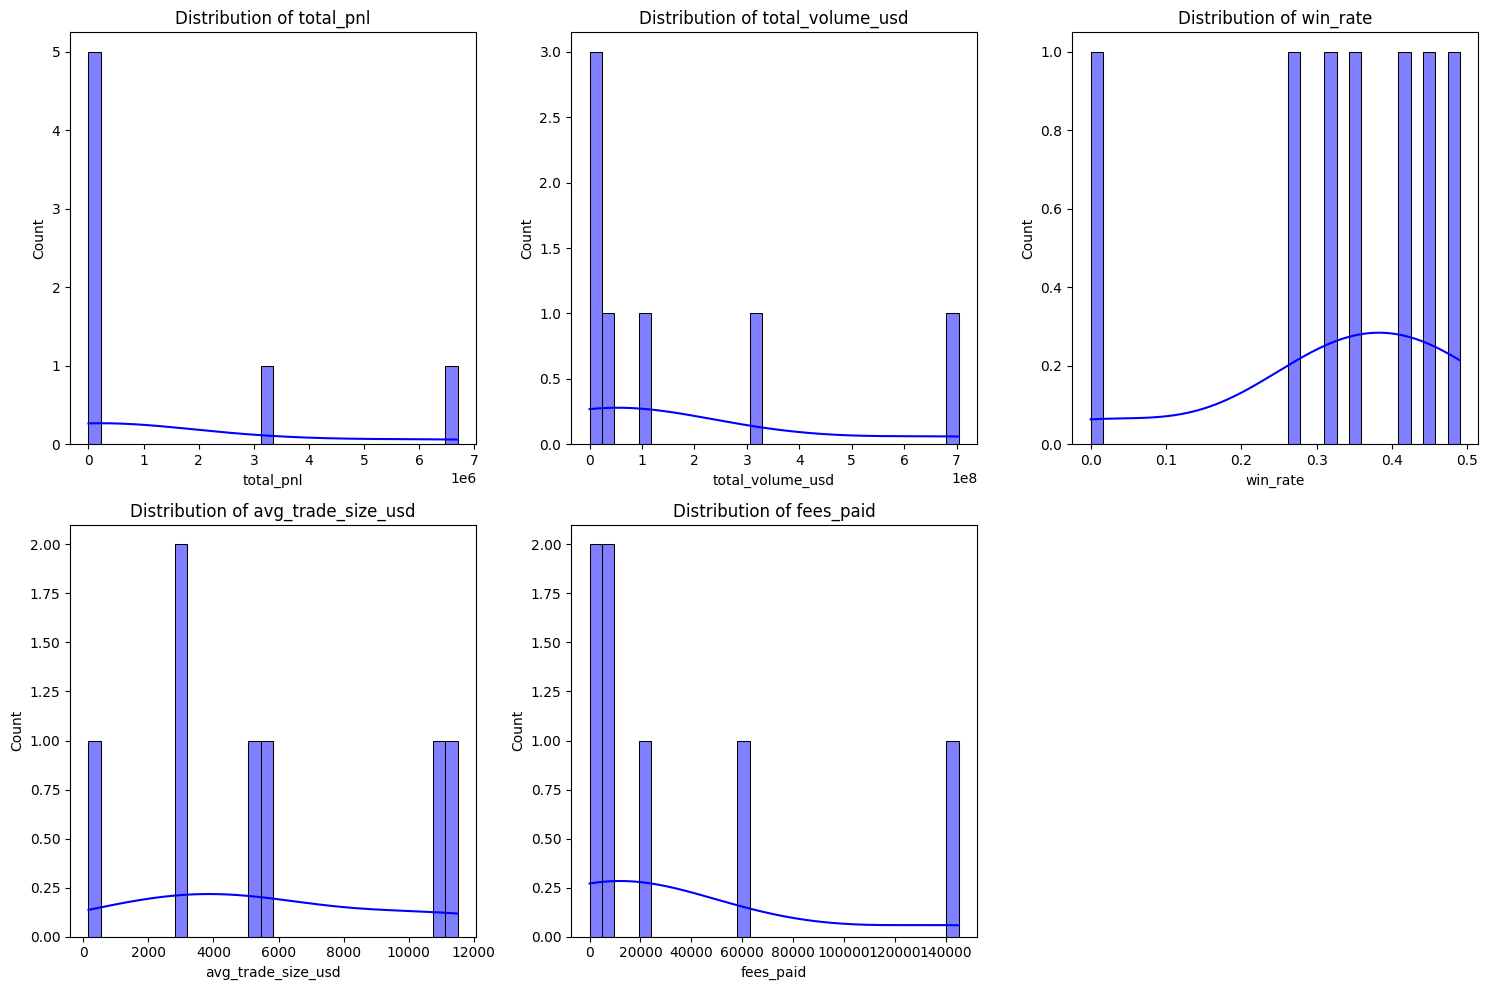

In [18]:
'''Most days have small profits and low volume, but a few rare days show huge increase in both, driving most results.
Win rates stay below 50%, meaning profits come from occasional big wins, not frequent small wins.'''

metrics_to_plot = ['total_pnl', 'total_volume_usd', 'win_rate', 'avg_trade_size_usd', 'fees_paid']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(merged_df[metric].dropna(), kde=True, bins=30, color='blue')#Kernel Density Estimate
    plt.title(f'Distribution of {metric}')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/distribution_plots.png')
plt.show()


# 3. Boxplots of metrics by Sentiment category (fear_greed_bin)

/tmp/ipython-input-2485310749.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fear_greed_bin', y=metric, data=merged_df, palette='Set2')
/tmp/ipython-input-2485310749.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fear_greed_bin', y=metric, data=merged_df, palette='Set2')
/tmp/ipython-input-2485310749.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fear_greed_bin', y=metric, data=merged_df, palette='Set2')
/tmp/ipython-input-2485310749.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

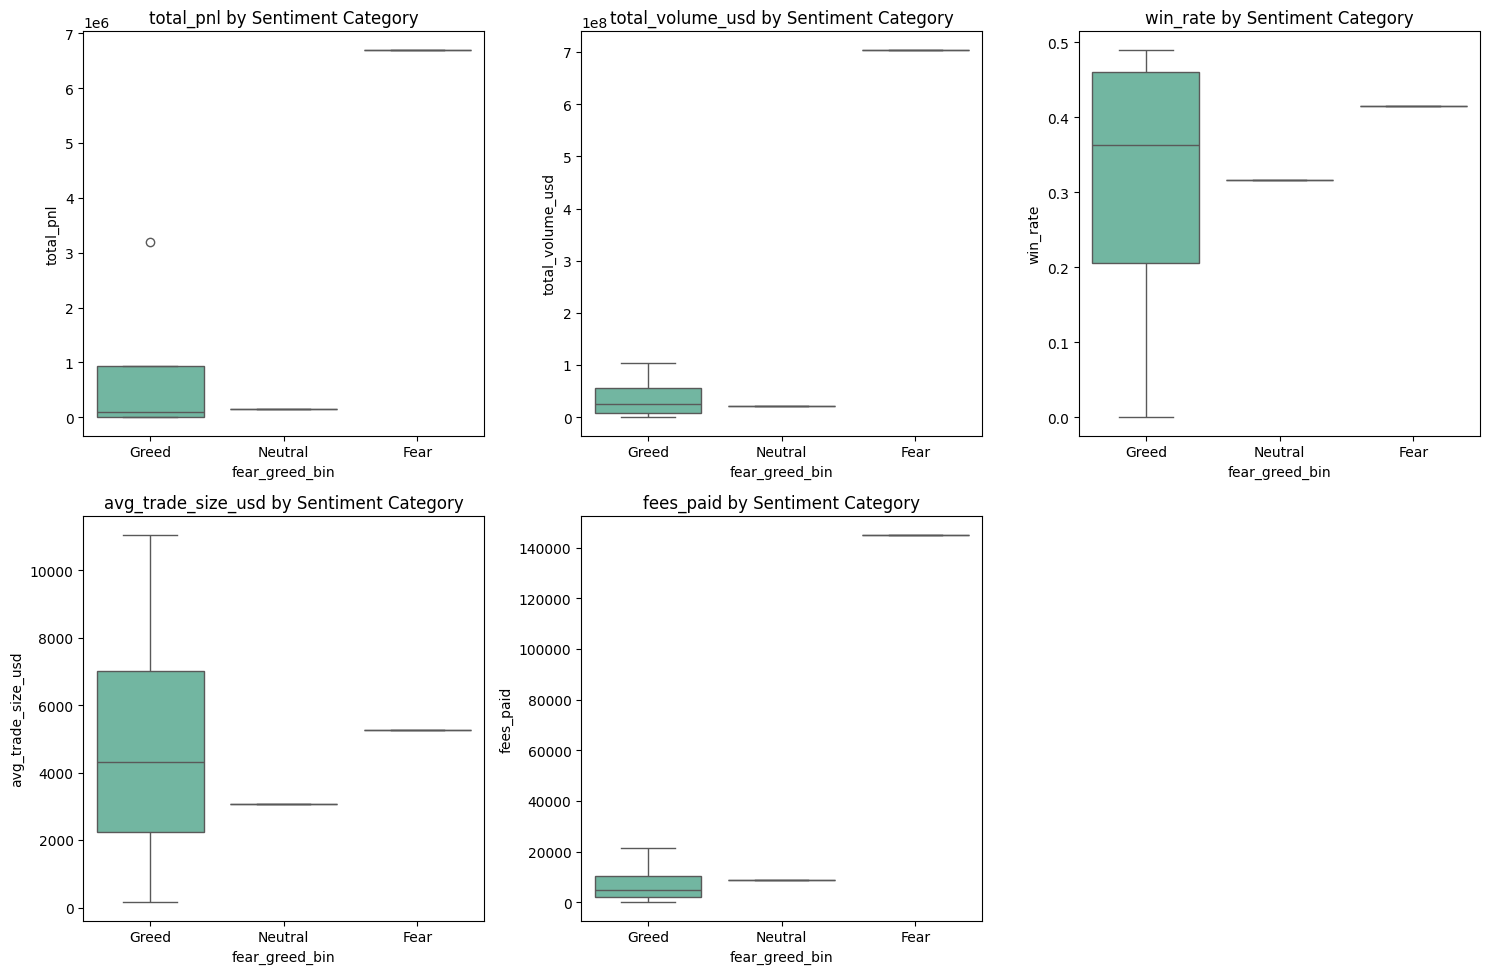

In [19]:
'''Greed days → more trades, more profit chances.
Fear days → few trades, but sometimes huge wins or losses.
Neutral days → slow and quiet trading.'''

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='fear_greed_bin', y=metric, data=merged_df, palette='Set2')
    plt.title(f'{metric} by Sentiment Category')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/boxplots.png')
plt.show()


## **4. Correlation heatmap of numerical features (including sentiment numeric)**

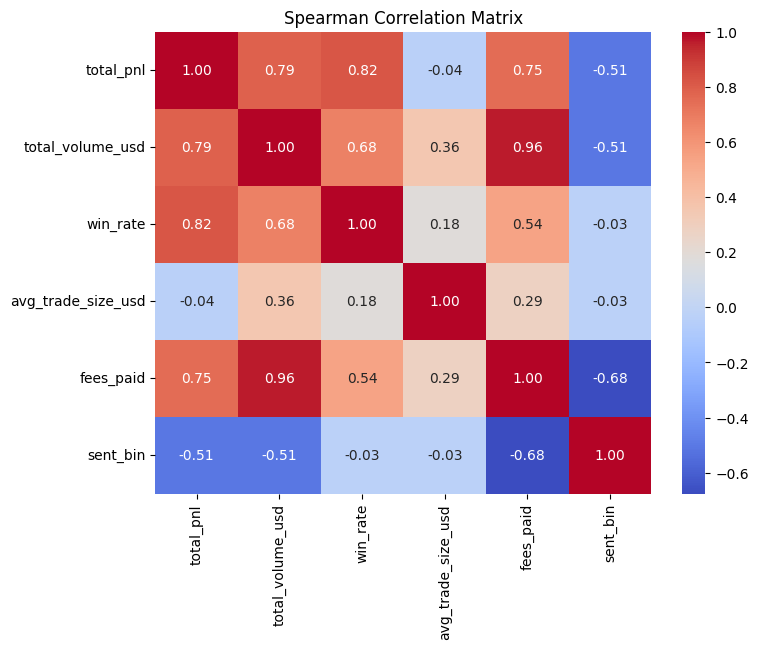

In [20]:

plt.figure(figsize=(8, 6))
sns.heatmap(
    merged_df[['total_pnl', 'total_volume_usd', 'win_rate', 'avg_trade_size_usd', 'fees_paid', 'sent_bin']].corr(method='spearman'),
    annot=True, fmt=".2f", cmap='coolwarm'
)
plt.title("Spearman Correlation Matrix")
# Save the figure to the outputs folder
plt.savefig('/content/outputs/correlation_matrix.png')
plt.show()


# 5. Total PnL over time by Fear/Greed Sentiment

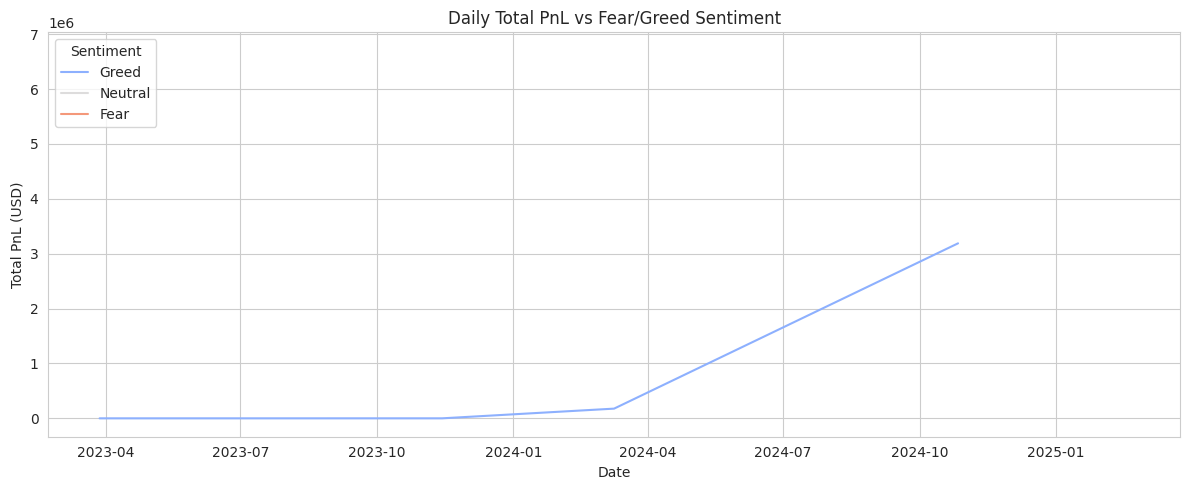

In [21]:

sns.set_style("whitegrid")

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_df, x='date', y='total_pnl', hue='fear_greed_bin', palette='coolwarm')
plt.title('Daily Total PnL vs Fear/Greed Sentiment')
plt.xlabel('Date')
plt.ylabel('Total PnL (USD)')
plt.legend(title='Sentiment')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/pnl_vs_sentiment.png')
plt.show()

# 6. Scatter plot: PnL vs Volume with hue by Sentiment category


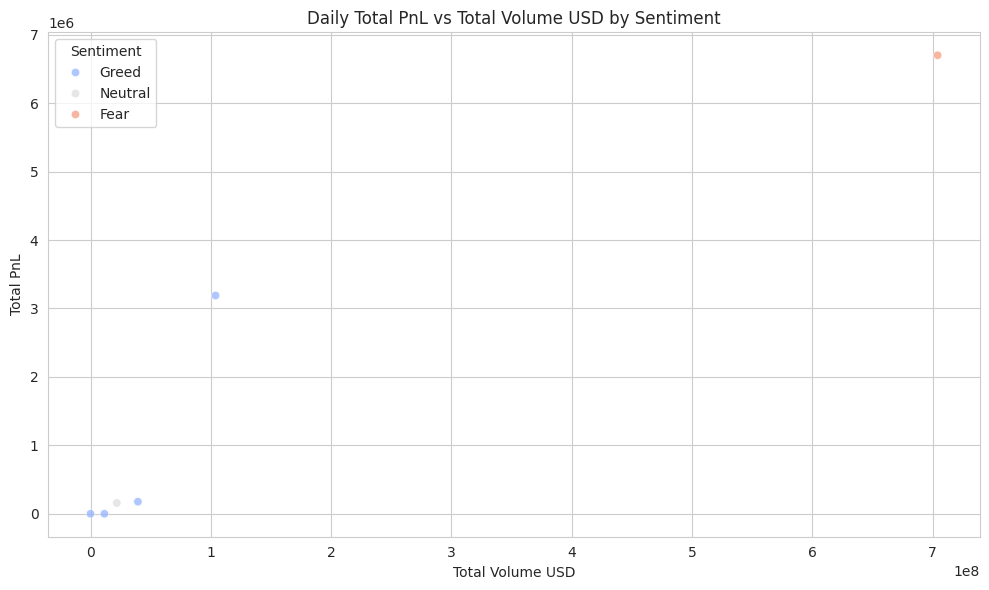

In [22]:
'''relationship between volume and profit, with sentiment as color.'''
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='total_volume_usd', y='total_pnl', hue='fear_greed_bin', palette='coolwarm', alpha=0.7)
plt.title('Daily Total PnL vs Total Volume USD by Sentiment')
plt.xlabel('Total Volume USD')
plt.ylabel('Total PnL')
plt.legend(title='Sentiment')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/pnl_vs_volume.png')
plt.show()


# 7. Bar plot of average Win Rate by Sentiment category

/tmp/ipython-input-704731007.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fear_greed_bin', y='win_rate', data=win_rate_means, palette='Set1')


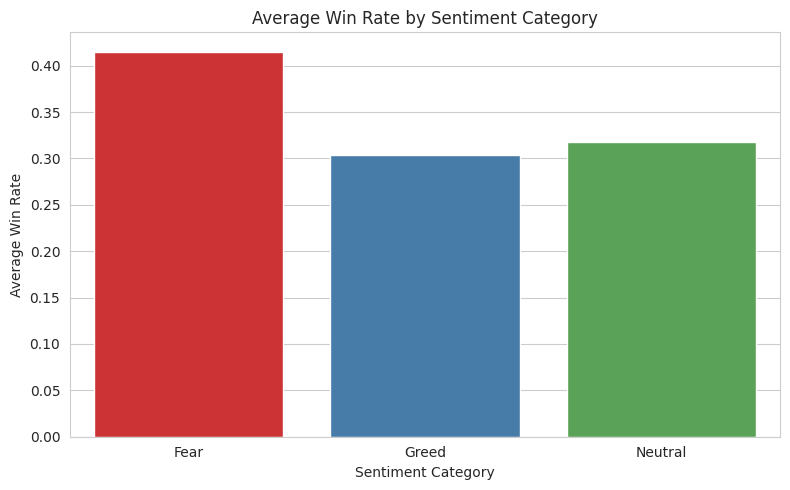

In [23]:
'''Bar chart of mean win_rate per sentiment category — quick comparison of trader success across sentiment.'''
win_rate_means = merged_df.groupby('fear_greed_bin')['win_rate'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='fear_greed_bin', y='win_rate', data=win_rate_means, palette='Set1')
plt.title('Average Win Rate by Sentiment Category')
plt.ylabel('Average Win Rate')
plt.xlabel('Sentiment Category')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/avgWinRate_by_sentiment.png')
plt.show()


# 8. Count plot: Number of days per Sentiment category

/tmp/ipython-input-971027028.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='fear_greed_bin', palette='pastel')


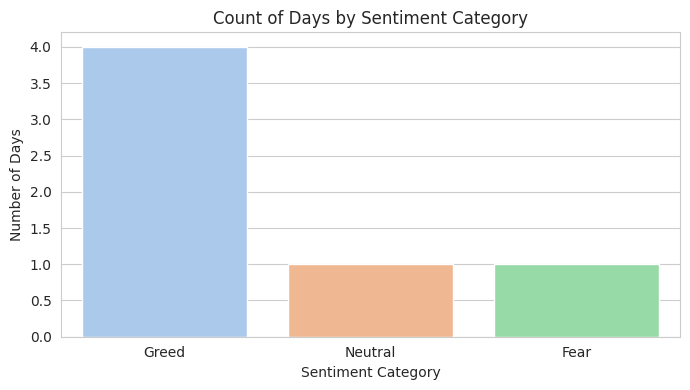

In [24]:
'''Shows how many days fall into each sentiment.'''
plt.figure(figsize=(7,4))
sns.countplot(data=merged_df, x='fear_greed_bin', palette='pastel')
plt.title('Count of Days by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Days')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/days_by_sentiment.png')
plt.show()


# 9. Time series of total trades by sentiment

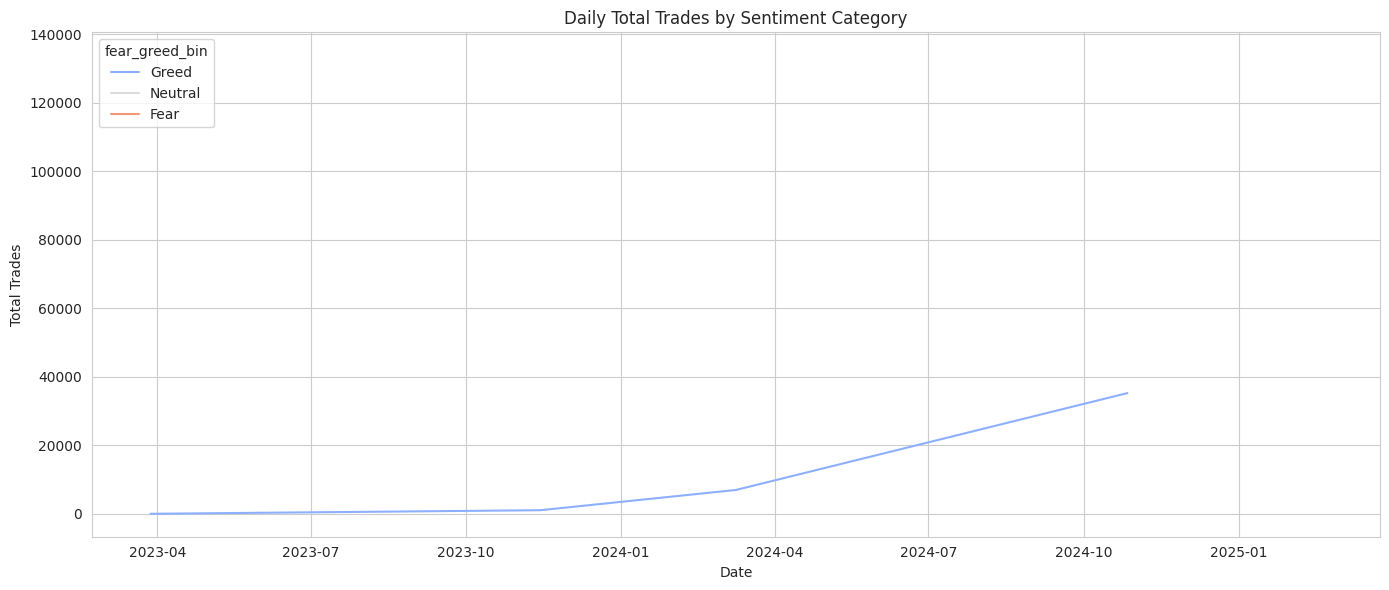

In [25]:
'''Line plot showing number of trades over time, colored by sentiment bin.'''
plt.figure(figsize=(14,6))
sns.lineplot(data=merged_df, x='date', y='total_trades', hue='fear_greed_bin', palette='coolwarm')
plt.title('Daily Total Trades by Sentiment Category')
plt.xlabel('Date')
plt.ylabel('Total Trades')
plt.tight_layout()
# Save the figure to the outputs folder
plt.savefig('/content/outputs/trade_by_sentiment.png')
plt.show()


# 10. Pairplot to explore relationships among key metrics colored by Sentiment (small sample to improve speed)


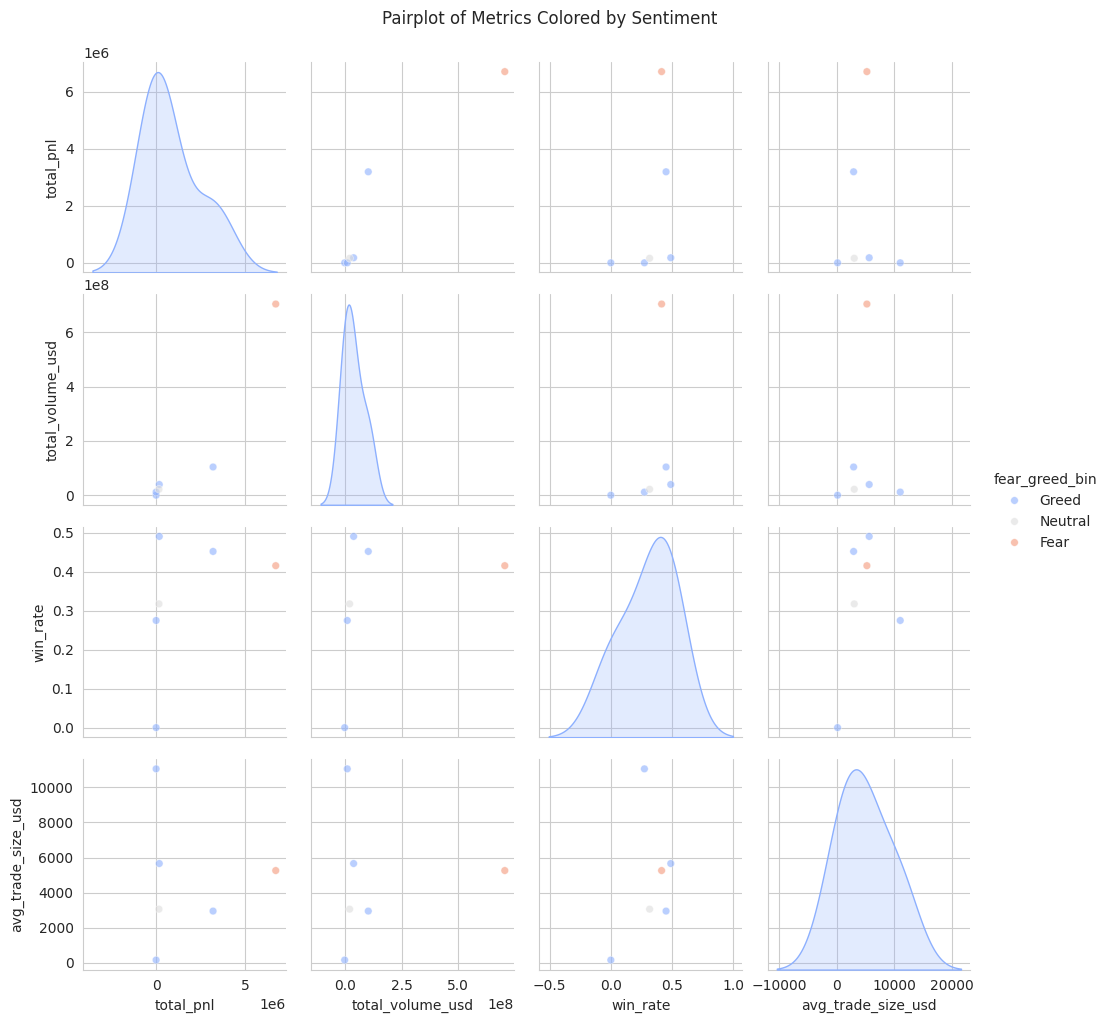

'pairplot can be slow on large datasets. Consider sampling (.sample(n=2000)) for speed.'

In [26]:
sns.pairplot(
    merged_df[['total_pnl', 'total_volume_usd', 'win_rate', 'avg_trade_size_usd', 'fear_greed_bin']].dropna(),
    hue='fear_greed_bin',
    palette='coolwarm',
    plot_kws={'alpha':0.6, 's':30}
)
plt.suptitle('Pairplot of Metrics Colored by Sentiment', y=1.02)
# Save the figure to the outputs folder
plt.savefig('/content/outputs/paiplot.png')
plt.show()

'''pairplot can be slow on large datasets. Consider sampling (.sample(n=2000)) for speed.'''

In [32]:
# Zip the outputs folder
shutil.make_archive('/content/outputs_zip', 'zip', '/content/outputs')

# Download the zip
from google.colab import files
files.download('/content/outputs_zip.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **8. Statistical Comparison: Fear vs Greed Days**

In [27]:
fear_days = merged_df[merged_df['fear_greed_bin'] == 'Fear']
greed_days = merged_df[merged_df['fear_greed_bin'] == 'Greed']

def mann_whitney_comparison(metric):
    """
    Perform Mann-Whitney U Test between Fear and Greed days on a given metric.
    Returns a summary dictionary.
    """
    fear_vals = fear_days[metric].dropna()
    greed_vals = greed_days[metric].dropna()
    stat, p_val = mannwhitneyu(fear_vals, greed_vals, alternative='two-sided')

    return {
        'metric': metric,
        'fear_mean': fear_vals.mean(),
        'greed_mean': greed_vals.mean(),
        'u_statistic': stat,
        'p_value': p_val
    }

metrics = ['total_pnl', 'total_volume_usd', 'win_rate', 'avg_trade_size_usd']
stat_results = pd.DataFrame([mann_whitney_comparison(m) for m in metrics])

print("\n=== Mann-Whitney U Test Results (Fear vs Greed) ===\n")
print(stat_results)



=== Mann-Whitney U Test Results (Fear vs Greed) ===

               metric     fear_mean    greed_mean  u_statistic  p_value
0           total_pnl  6.699925e+06  8.416455e+05          4.0      0.4
1    total_volume_usd  7.041585e+08  3.872761e+07          4.0      0.4
2            win_rate  4.151459e-01  3.040837e-01          2.0      1.0
3  avg_trade_size_usd  5.259978e+03  4.956680e+03          2.0      1.0


# **9. Correlation Analysis between Sentiment and Trade Metrics**

In [28]:
sentiment_numeric_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}

merged_df['sent_bin_num'] = merged_df['classification'].map(sentiment_numeric_map)

corr_matrix = merged_df[['total_pnl', 'total_volume_usd', 'win_rate', 'avg_trade_size_usd', 'sent_bin_num']].corr(method='spearman')

print("\n=== Spearman Correlation Matrix ===\n")
print(corr_matrix)


=== Spearman Correlation Matrix ===

                    total_pnl  total_volume_usd  win_rate  avg_trade_size_usd  \
total_pnl            1.000000          0.785714  0.821429           -0.035714   
total_volume_usd     0.785714          1.000000  0.678571            0.357143   
win_rate             0.821429          0.678571  1.000000            0.178571   
avg_trade_size_usd  -0.035714          0.357143  0.178571            1.000000   
sent_bin_num        -0.333947         -0.333947  0.273230            0.151794   

                    sent_bin_num  
total_pnl              -0.333947  
total_volume_usd       -0.333947  
win_rate                0.273230  
avg_trade_size_usd      0.151794  
sent_bin_num            1.000000  


## **10. SAVE CLEANED MERGED DATA**

In [29]:
# Create folder if it doesn't exist
os.makedirs('/content/csv_files', exist_ok=True)

# Save your DataFrame as CSV inside Colab VM
merged_df.to_csv('/content/csv_files/merged_sentiment_trader.csv', index=False)
files.download('/content/csv_files/merged_sentiment_trader.csv')
print("\nMerged dataset saved to csv_files/merged_sentiment_trader.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Merged dataset saved to csv_files/merged_sentiment_trader.csv
